In [1]:
category = 'bridge'

# Imports

In [2]:
import os
from pathlib import Path

In [3]:
import numpy as np

In [4]:
import torch

In [5]:
import clip

In [6]:
from PIL import Image, ImageDraw, ImageOps

In [7]:
from tqdm import tqdm

In [8]:
import matplotlib.pyplot as plt

In [9]:
import logging

## Configs

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setup

In [11]:
prefix = 'sketch of a'

---

In [12]:
# categories = [category] + ['orange', 'tangerine', 'grapefruit', 'lemon']
categories = [dirpath.name for dirpath in Path('data/sketch').glob('[!.]*')]

In [13]:
categories[np.argwhere(np.array(categories) == category).squeeze()] = categories[0]
categories[0] = category

In [14]:
labels = [f'{prefix} {label}'for label in categories]

In [15]:
model, preprocess = clip.load('ViT-B/32', device=device)

## Functions and Classes

In [16]:
class Im():
    BASE_DIR = 'data/sketch'

    def __init__(self, basename, category=category, prefix=''):
        self.category = category
        self.dirname = Path(Im.BASE_DIR, self.category, prefix)
        self.basename = basename
        self.path = self.dirname / self.basename
        if self.path.is_file():
            self.image = Image.open(self.path)

    def apply(self, func, *args, **kwargs):
        self.image = func(self.image, *args, **kwargs)
        return self

    def save(self, prefix=''):
        filepath = self.dirname / prefix / self.basename
        filepath.parent.mkdir(parents=True, exist_ok=True)
        self.image.save(filepath)

    def _ipython_display_(self):
        if self.image:
            display(self.image)

---

In [17]:
def create_mask(size, step):
    image = Image.new('1', size, 'black')
    width, height = size
    image_draw = ImageDraw.Draw(image)
    for x in range(0, width - step + 1, step):
        for y in range(0, height - step + 1, step):
            image_draw.ellipse((x, y, x + step, y + step), fill = 'white', outline ='white')
    return image

In [18]:
def grid_cell_value(image, step, x, y, shape='square'):
    image = np.array(image)
    if shape == 'square':
        return image[x-int(step/2):x+int(step/2), y-int(step/2):y+int(step/2)].any()
    elif shape == 'circle':
        for (i, j), v in np.ndenumerate(image[x-int(step/2):x+int(step/2), y-int(step/2):y+int(step/2)]):
            if (np.sqrt((i - step/2)**2 + (j - step/2)**2) < (step/2)**2) and v:
                return True

In [19]:
def pixelate(image, step):
    return image.resize(tuple(map(lambda s: int(s / step), image.size)), resample=Image.Resampling.BILINEAR).convert('1').resize(image.size, Image.Resampling.NEAREST)

In [20]:
def mask_grid(image, step=16): #step=11
    # return Image.fromarray(np.array(create_mask(image.size, step)) * np.array(image))

    # grid_image = np.zeros(image.size, dtype=bool)
    # for x, y in zip(*map(np.ravel, np.mgrid[0:image.size[0]:int(step/2), 0:image.size[1]:int(step/2)])):
    #     grid_image[x-int(step/2):x+int(step/2), y-int(step/2):y+int(step/2)] = grid_cell_value(image, step, x, y)
    # grid_image = Image.fromarray(grid_image)
    # return grid_image

    return pixelate(image, step)

---

In [21]:
def shift_and_scale(image):
    pass

---

In [22]:
def show_images(filenames):
    if not len(filenames):
        logging.debug('[No files]')
        return
    fig, axs = plt.subplots(int(np.ceil(len(filenames)/10)), 10, figsize=(20, int(np.ceil(len(filenames)/10))*2), sharex=True, sharey=True)
    fig.set_facecolor('black')
    axs = iter(axs.ravel())
    for filename in filenames[::-1]:
        ax = next(axs)
        ax.imshow(Im(f'{filename}.png', prefix=f'pre-processed_{step}').image, cmap='binary')
        ax.set_title(f'{results[filename][0]*100:.2f}', color='white')
        ax.axis('off')
    for ax in axs:
        ax.axis('off')

# Main

In [23]:
step = 10

In [24]:
overwrite = True

## Preprocess

In [25]:
# Pre-process Images
for basename in tqdm(os.listdir(dirname:=Path(Im.BASE_DIR, category))):
    if (dirname / basename).is_file():
        # Convert to *grid-style*
        if not (dirname / f'pre-processed_{step}' / basename).is_file() or overwrite:
            file = Im(basename, category)
            file.apply(ImageOps.invert)
            file.apply(mask_grid, step)
            file.save(f'pre-processed_{step}')
        else:
            file = Im(basename, category, f'pre-processed_{step}')

        # Process for CLIP
        if not (filepath:=dirname / f'processed_{step}' / (basename.split('.')[0] + '.pt')).is_file() or overwrite:
            image = preprocess(file.image).unsqueeze(0).to(device)
            filepath.parent.mkdir(parents=True, exist_ok=True)
            torch.save(image, filepath)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:01<00:00, 79.71it/s]


In [26]:
# Pre-process Labels
text = clip.tokenize(labels).to(device)

## Inference

In [27]:
results = dict()
for basename in tqdm(os.listdir(dirname:=Path(Im.BASE_DIR, category, f'processed_{step}'))):
    if (filepath:=dirname / basename).is_file():
        image = torch.load(filepath, map_location=device)
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)

            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        results[basename.split('.')[0]] = probs.squeeze()
        # print(f'Label probs: {probs}')
        # print(f'Label: {labels[np.argmax(probs)]}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [29:54<00:00, 22.44s/it]


# Results

In [28]:
results = dict(sorted(results.items(), key=lambda r: r[1][0]))

In [29]:
right_images = list(filter(lambda filename: np.argmax(results[filename]) == 0, results))
wrong_images = list(filter(lambda filename: np.argmax(results[filename]) != 0, results))

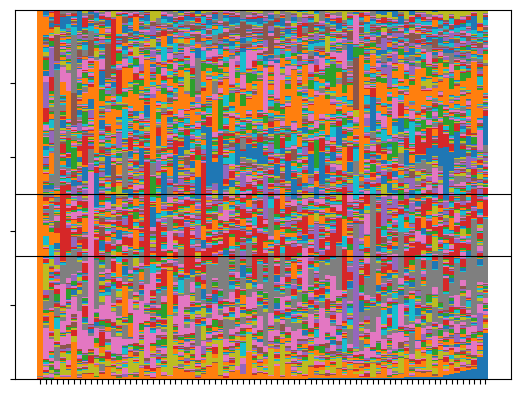

In [30]:
bottom = 0
for i in range(len(categories)):
    plt.bar(list(results.keys()), np.array(list(results.values()))[:, i], 1, bottom=bottom, label=categories[i])
    bottom += np.array(list(results.values()))[:, i]
plt.tick_params(labelbottom=False, labelleft=False)
plt.axhline(1/3, c='k', lw=0.8)
plt.axhline(0.5, c='k', lw=0.8)
# plt.axis('off')
# plt.legend()
plt.show()

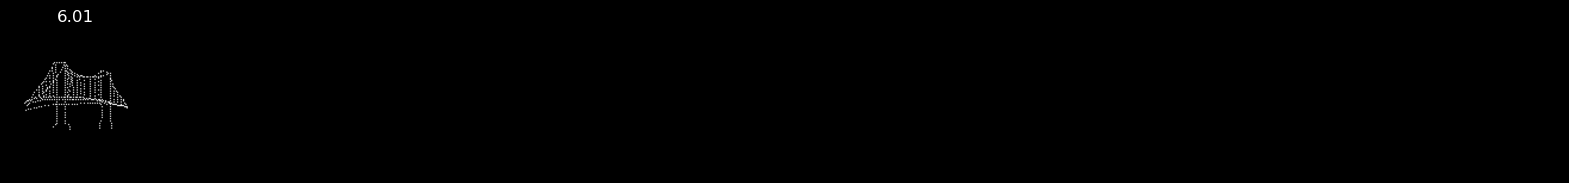

In [31]:
show_images(right_images)

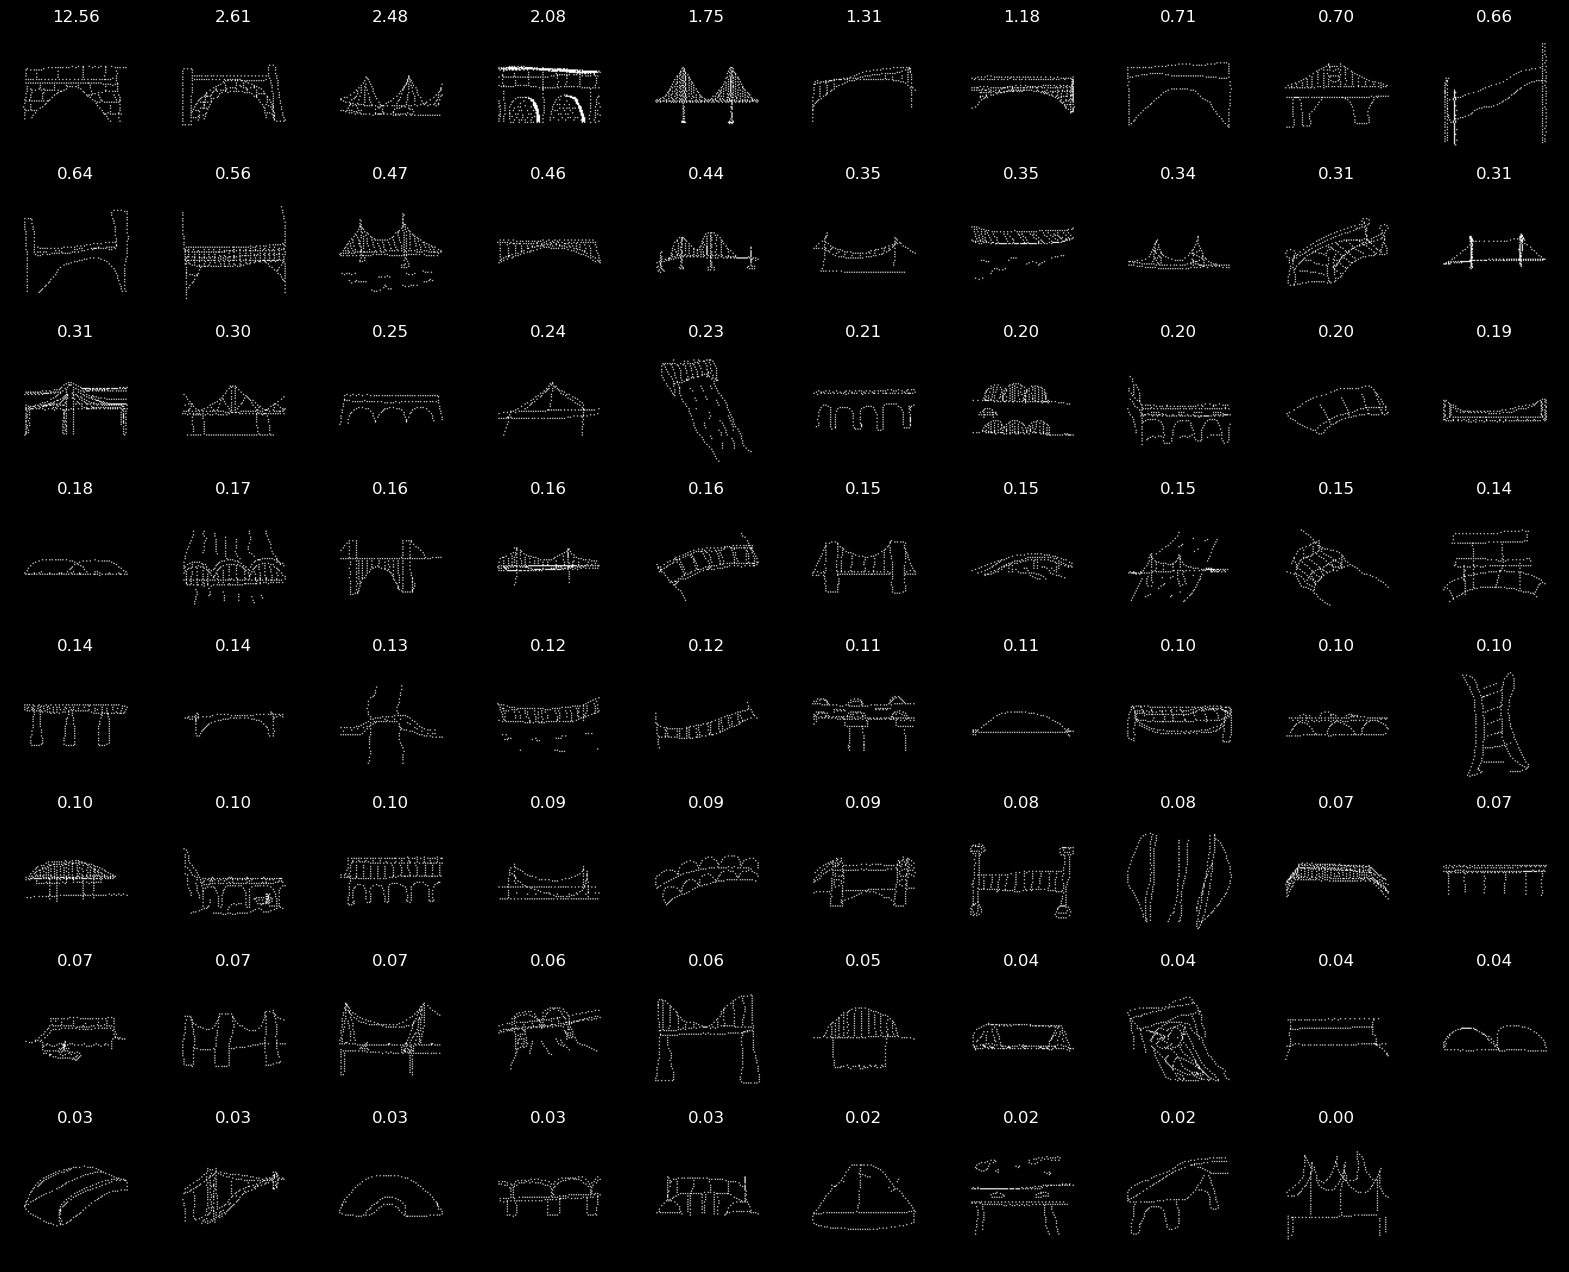

In [32]:
show_images(wrong_images)